# Ramsey Fringes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize

import logging


In [3]:
import qt3utils.experiments.ramsey
import qt3utils.experiments.cwodmr
import qt3utils.experiments.podmr
import qt3utils.experiments.rabi

from qt3utils.experiments.pulsers.pulseblaster import PulseBlasterRamHahnDD, PulseBlasterCWODMR, PulseBlasterPulsedODMR, PulseBlasterHoldAOM
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

import nipiezojenapy
import qt3utils.datagenerators as datasources
import qt3utils.datagenerators.piezoscanner
import qt3utils.nidaq.config

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [4]:
logging.basicConfig(level=logging.WARNING)

In [5]:
qt3utils.experiments.ramsey.logger.setLevel(logging.INFO)
qt3utils.experiments.cwodmr.logger.setLevel(logging.INFO)
qt3utils.experiments.podmr.logger.setLevel(logging.INFO)
qt3utils.experiments.rabi.logger.setLevel(logging.INFO)

# Create objects to control hardware

In [6]:
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [7]:
aom_hold = PulseBlasterHoldAOM()

In [8]:
aom_hold.program_pulser_state()

0

In [9]:
cwodmr_pulser = PulseBlasterCWODMR(clock_period = 200e-9)

In [10]:
podmr_pulser = PulseBlasterPulsedODMR(clock_period = 100e-9)

In [11]:
ramsey_pulser = PulseBlasterRamHahnDD(clock_period=100e-9)

In [12]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

In [26]:
# Eventually, these functions should be moved to the package somewhere -- either analysis or in experiments
def aggregate_data(data_buffer, experiment):
    return data_buffer.reshape(int(experiment.N_cycles), int(experiment.N_clock_ticks_per_cycle)).mean(axis=0)

def podmr_simple_signal_background(trace):
    background = trace[:len(trace)//2]
    signal = trace[len(trace)//2:]
    return np.sum(signal)/np.sum(background)

def cwodmr_simple_signal_background(trace):
    rf_on = trace[:len(trace)//2]
    rf_off = trace[len(trace)//2:]
    return np.sum(rf_on)/np.sum(rf_off)

def measure_cwodrm_contrast(data_buffer, experiment):
    return cwodmr_simple_signal_background(aggregate_data(data_buffer, experiment))

def measure_podmr_contrast(data_buffer, experiment):
    return podmr_simple_signal_background(aggregate_data(data_buffer, experiment))

# Confocal Scan
Either run a scan here in the notebook, or use qt3scan and save. qt3scan was used and we load the scan here

In [14]:
scan_file = 'detail_scan_ppm_0.034mW_x_8_to_24_y_10_to_28.npy'
confocal_scan = np.load(scan_file)

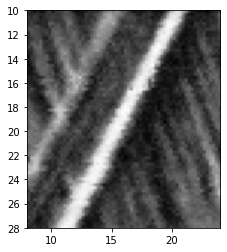

In [24]:
plt.imshow(confocal_scan, cmap='Greys_r', extent = [8, 24, 28, 10])

In [ ]:
#centered the stage around
#x = 16
#y = 18.3
#z = 37.5

# CWODMR
First without a magent

In [16]:
cwodmr_exp = qt3utils.experiments.cwodmr.CWODMR(cwodmr_pulser, rfsynth, nidaq_config)

In [17]:
cwodmr_exp.freq_step = 1e6

In [18]:
cwodmr_exp.experimental_conditions()

{'freq_low': 2820000000.0,
 'freq_high': 2920000000.0,
 'freq_step': 1000000.0,
 'rf_power': -20,
 'pulser': {'rf_pulse_duration': 5e-06, 'clock_period': 2e-07}}

In [ ]:
cwscan = cwodmr_exp.run(N_cycles=100000, post_process_function=measure_cwodrm_contrast)

Text(0.5, 0, 'frequency [Hz]')

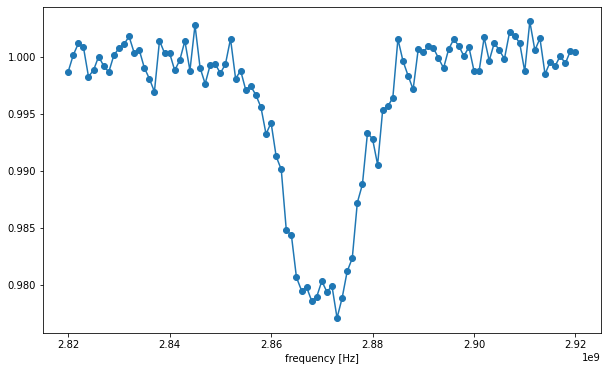

In [28]:
cwscan = np.array(cwscan)

x_data = cwscan[:, 0]
y_data = cwscan[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('frequency [Hz]')


In [33]:
cwodmr_exp.freq_low = 2750e6
cwodmr_exp.freq_high = 3200e6
cwodmr_exp.freq_step = 2.5e6

In [ ]:
#adding small magnet nearby
cwscan_b_ext = cwodmr_exp.run(N_cycles=100000, post_process_function=measure_cwodrm_contrast)

Text(0.5, 0, 'frequency [Hz]')

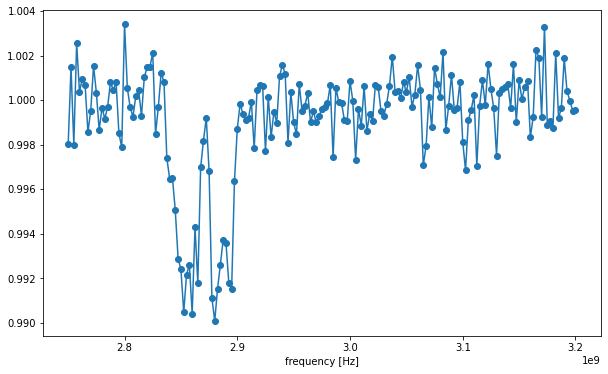

In [35]:
cwscan_b_ext = np.array(cwscan_b_ext)

x_data = cwscan_b_ext[:, 0]
y_data = cwscan_b_ext[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('frequency [Hz]')


In [36]:
cwodmr_exp.freq_low = 2820e6
cwodmr_exp.freq_high = 2920e6
cwodmr_exp.freq_step = 0.5e6

In [ ]:
cwscan_b_ext = cwodmr_exp.run(N_cycles=100000, post_process_function=measure_cwodrm_contrast)

Text(0.5, 0, 'frequency [Hz]')

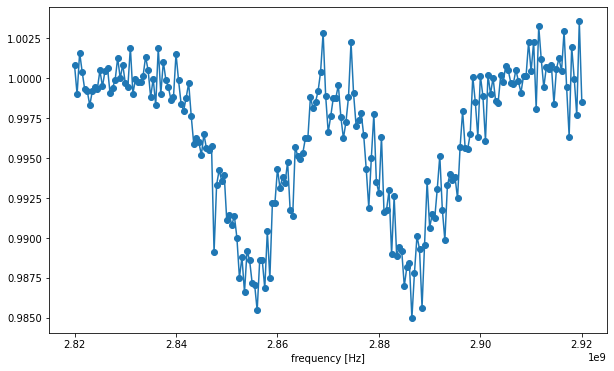

In [38]:
cwscan_b_ext = np.array(cwscan_b_ext)

x_data = cwscan_b_ext[:, 0]
y_data = cwscan_b_ext[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('frequency [Hz]')


# Instantiate an experiment object

In [10]:
experiment = qt3utils.experiments.ramsey.Ramsey(pulser, rfsynth, nidaq_config, 
                                            photon_counter_nidaq_terminal = 'PFI0',
                                            clock_nidaq_terminal = 'PFI12',
                                            rf_power = -25)

In [11]:
experiment.experimental_conditions()

{'tau_low': 1e-06,
 'tau_high': 1e-05,
 'tau_step': 2e-07,
 'rf_power': -25,
 'rf_frequency': 2870000000.0,
 'pulser': {'rf_pi_pulse_width': 1e-06,
  'aom_width': 5e-06,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': None,
  'free_precession_time': 5e-06,
  'clock_period': 2e-07}}

In [ ]:
scan_data = experiment.run(N_cycles=5000)

# Observe the Data

In [13]:
def plot_trace(trace, N_cycles=1, clock_rate=1, label = None):
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate, label = label)

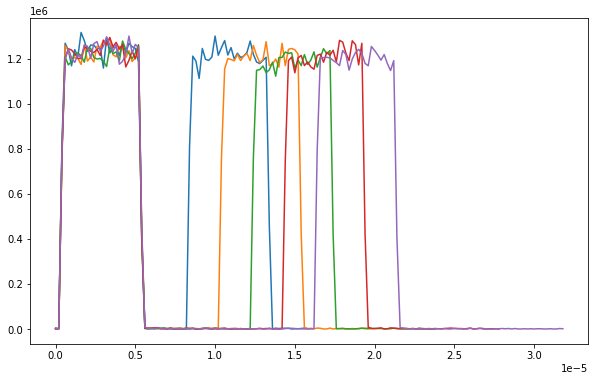

In [14]:
fig, ax = plt.subplots(figsize=(10,6))

for scan in scan_data[::10]:
    
    plot_trace(scan[1], experiment.N_cycles, clock_rate = 1./experiment.pulser.clock_period, label = scan[0])
    
# for freq in list(combined_scans.keys())[::5]:
#     plot_trace(combined_scans[freq], cwodmr.N_cycles, clock_rate = 1./cwodmr.clock_period)

Instead of workding directly with the averaged raw data, we can use a built-in function that will measure the contrast directly between the first PL readout (AOM initialization) and the second PL readout (after Ramsey MW sequence)


In [ ]:
scan_data = experiment.run(N_cycles=100000, 
                           post_process_function = qt3utils.experiments.ramsey.measure_contrast)

# Build and Plot Contrast

Text(0.5, 0, 'width [s]')

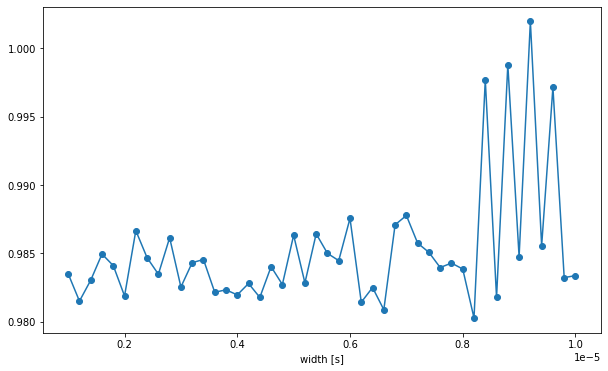

In [23]:
scan_data = np.array(scan_data)

x_data = scan_data[:, 0]
y_data = scan_data[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('width [s]')


## Change some parameters if you wish

In [24]:
experiment.experimental_conditions()

{'tau_low': 1e-06,
 'tau_high': 1e-05,
 'tau_step': 2e-07,
 'rf_power': -25,
 'rf_frequency': 2870000000.0,
 'pulser': {'rf_pi_pulse_width': 1e-06,
  'aom_width': 5e-06,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': 3.4e-05,
  'free_precession_time': 1e-05,
  'clock_period': 2e-07}}

In [29]:
#modify these as you see fit
experiment.tau_step = 50e-9
experiment.tau_high = 15e-6
experiment.pulser.aom_width = 5e-6
experiment.rf_power = -30

In [30]:
experiment.experimental_conditions()

{'tau_low': 1e-06,
 'tau_high': 1.5e-05,
 'tau_step': 5e-08,
 'rf_power': -30,
 'rf_frequency': 2870000000.0,
 'pulser': {'rf_pi_pulse_width': 1e-06,
  'aom_width': 5e-06,
  'aom_response_time': 8e-07,
  'post_rf_pad': 1e-07,
  'pre_rf_pad': 1e-07,
  'full_cycle_width': 4.4e-05,
  'free_precession_time': 1.5e-05,
  'clock_period': 2e-07}}

# Take Data

In [ ]:
scan_data = experiment.run(N_cycles=50000,
                          post_process_function = qt3utils.experiments.ramsey.measure_contrast)

# Build and Plot Contrast

Text(0.5, 0, 'width [s]')

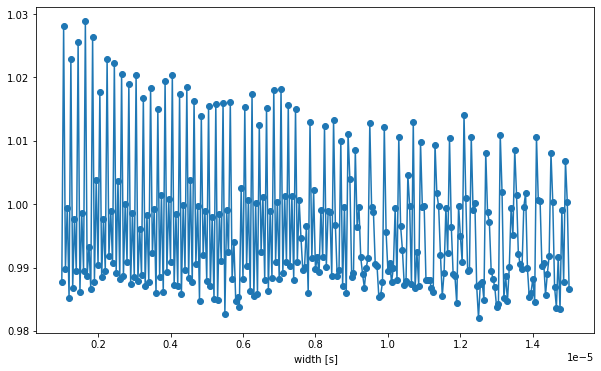

In [32]:
scan_data = np.array(scan_data)

x_data = scan_data[:, 0]
y_data = scan_data[:, 1]

plt.figure(figsize=(10, 6))
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('width [s]')
